## SenNetworks: Hacking the Human Vasculature in 3D Transformers Solution

#### Transformer Notebook Author: Andrew Kettle

In [1]:
# Packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pandas as pd
import os
import shutil
import transformers # Hugging Face for Segformer models
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm
from torchinfo import summary
from sklearn.model_selection import train_test_split
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

### Dataset
The following few cells implement the data ingestion functions for the kidney dataset. The dataset and dataloader are both implemented using the base PyTorch classes. 

In [82]:
# Dataset that is passed to dataloader
class SenDataset(torch.utils.data.Dataset):

	def __init__(self, run_type, feature_extractor):
		self.run_type = run_type
		self.feature_extractor = feature_extractor
		self.image_paths = []
		self.label_paths = []

	def setPaths(self, image_paths, label_paths):
		self.image_paths = image_paths

		# Guard
		if self.run_type != 'test':
			self.label_paths = label_paths

	def setImagePath(self, image_paths):
		self.image_paths = image_paths
	
	def importTif(self, path, gray: bool):
		image = cv2.imread(path) # Read
		if gray:
			# Grab a single channel for label
			image = cv2.imread(path)[:,:,0] # R=G=B, so index can be [0,1,2]

		return image

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):

		if self.run_type != 'test':
			# Grab image and label from disk
			image = self.importTif(self.image_paths[idx], False)
			label = self.importTif(self.label_paths[idx], True)

			# Scale label, do this because Segformer uses 255 as an "ignore index"
			label = (label / 255).astype('uint8') # Scale to [0,1]

			# Prepare inputs for segformer using SegformerImageProcessor
			encoded_inputs = self.feature_extractor(image, label, return_tensors='pt')
			for k,v in encoded_inputs.items():
				encoded_inputs[k].squeeze_() # remove batch axis

			# Only need image and labels for our implementation
			image = encoded_inputs['pixel_values']
			label = encoded_inputs['labels']

			return image, label

		else:
			# Grab image from disk (no label provided for test set)
			image = self.importTif(self.image_paths[idx], False)

			# Prepare inputs for segformer using SegformerImageProcessor
			encoded_inputs = self.feature_extractor(image, return_tensors='pt')
			for k,v in encoded_inputs.items():
				encoded_inputs[k].squeeze() # remove batch axis

			image = encoded_inputs['pixel_values']
			return image, ''

# Rename items in the dataset so there is no overlap (only run this once!)
def renameDataset():
	root_dir = os.path.join(os.getcwd(), "data")
	train_dir = os.path.join(root_dir, "train")

	paths = os.listdir(train_dir)
	paths = [os.path.join(train_dir, p) for p in paths]

	# Iterate over each subset
	for p in paths:	
		
		image_path = os.path.join(p, "images")
		label_path = os.path.join(p, "labels")
		image_names = os.listdir(image_path)
		label_names = os.listdir(label_path)

		# Name to append for each file (splitting is platform specific)
		append_name = p.split('/')[-1]

		revised_image_names = [append_name + '_' + name for name in image_names]
		revised_label_names = [append_name + '_' + name for name in label_names]

		# Rename images
		for iname, upiname in zip(image_names, revised_image_names):
			shutil.move(os.path.join(image_path, iname), os.path.join(image_path, upiname))
		# Rename labels
		for lname, uplname in zip(label_names, revised_label_names):
			shutil.move(os.path.join(label_path, lname), os.path.join(label_path, uplname))

# Populate numpy array with necessary dataset information
def buildDataset(root_dir: str, run_type: str):
	""" Populate the image and label arrays

	Args:
		root_dir (str): Path to root dir (where training or testing may take place)
		run_type (str): either 'train' or 'test'
	"""

	image_paths = []
	label_paths = []

	# Logic for training or testing
	if run_type == 'train':
		working_dir = os.path.join(root_dir, "train")
	elif run_type == 'test':
		working_dir = os.path.join(root_dir, "test")
	else:
		print("Unsupported run_type in the buildDataset function")
		assert(False) # Quick hack to exit execution

	paths = os.listdir(working_dir)
	paths = [os.path.join(working_dir, p) for p in paths]

	for p in paths:

		image_path = os.path.join(p, "images")
		image_names = [os.path.join(image_path, name) for name in os.listdir(image_path)]
		image_paths.append(np.array(image_names))

		if run_type == 'train':
			label_path = os.path.join(p, "labels")
			label_names = [os.path.join(label_path, name) for name in os.listdir(label_path)]
			label_paths.append(np.array(label_names))
	
	image_paths = np.concatenate(image_paths)

	if run_type == 'train':
		label_paths = np.concatenate(label_paths)

	return image_paths, label_paths

In [ ]:
# Cell for calculating the image mean and standard deviation of the dataset.
# We resize to 512x512 so that everything is standardized

root_dir = os.path.join(os.getcwd(), "data")
train_dir = os.path.join(root_dir, "train")

paths = os.listdir(train_dir)
paths = [os.path.join(train_dir, p) for p in paths]

us = 0
stds = 0
its = 0

# Iterate over each subset
for p in paths:	
	
	image_path = os.path.join(p, "images")
	image_names = os.listdir(image_path)

	for name in image_names:
		image = cv2.imread(os.path.join(image_path, name))
		image = cv2.resize(image, (512, 512))
		us = us + np.mean(image) 
		stds = stds + np.std(image) 
		its+=1

print(us / float(its))
print(stds / float(its))

In [83]:
# Ingest data, store in numpy arrays
Xtr, Ytr = buildDataset(os.path.join(os.getcwd(), 'data'), 'train')
# Temporary Testing
print(f"Xtr.shape: {Xtr.shape} Ytr.shape: {Ytr.shape}")

Xte, _ = buildDataset(os.path.join(os.getcwd(), 'data'), 'test')
print(f"Xte.shape: {Xte.shape}")

Xtr.shape: (2279,) Ytr.shape: (2279,)
Xte.shape: (6,)


#### Cleaning

Observe that the training set has fewer labels than images. Since we are data rich, we will elect to toss out the samples that don't have labels for the sake of simplicity.

In [84]:
# Trim file extensions
a = np.array([x.split('.')[0].split('/')[-1] for x in Xtr])
b = np.array([y.split('.')[0].split('/')[-1] for y in Ytr])

# Find overlap
c = np.where(np.intersect1d(a, b))

# Drop extra items from training set
Xtr = Xtr[c]

Split data into training and testing using 80/20 split

In [85]:
# Split dataset into training and validation
Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=0.2, shuffle=True)
print(f"Xtr: {Xtr.shape}, Ytr: {Ytr.shape}")
print(f"Xval: {Xval.shape}, Yval: {Yval.shape}")

Xtr: (1823,), Ytr: (1823,)
Xval: (456,), Yval: (456,)


#### Create dataset and dataloader

In [86]:
# Numbers extracted from mean and std calculation function
image_mean = 103.84
image_std = 7.92

# Create preprocessing routine for segformer (sometimes called feature_extractor)
feature_extractor_train = transformers.SegformerImageProcessor()
feature_extractor_test = transformers.SegformerImageProcessor(do_normalize=False) # Test images shouldn't know about training

# Create datasets and set paths
trds = SenDataset('train', feature_extractor_train)
trds.setPaths(Xtr, Ytr)

valds = SenDataset('validation', feature_extractor_train)
valds.setPaths(Xval, Yval)

teds = SenDataset('test', feature_extractor_test)
teds.setImagePath(Xte)

# Maximum size that an RTX3080 with 12GB VRAM could handle.
# NOTE: Graders / TAs, you may have to change this if your hardware is less performant.  
batch_size = 8

train_loader = torch.utils.data.DataLoader(trds, batch_size=batch_size, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valds, batch_size=batch_size, num_workers=4)
test_loader = torch.utils.data.DataLoader(teds, batch_size=1) # Batch size 1 for testing

['/home/andrew/school/grad/fall23/SenNetworks/data/train/kidney_1_dense/images/kidney_1_dense_0758.tif'
 '/home/andrew/school/grad/fall23/SenNetworks/data/train/kidney_1_dense/images/kidney_1_dense_2237.tif'
 '/home/andrew/school/grad/fall23/SenNetworks/data/train/kidney_1_dense/images/kidney_1_dense_0160.tif'
 ...
 '/home/andrew/school/grad/fall23/SenNetworks/data/train/kidney_1_dense/images/kidney_1_dense_1746.tif'
 '/home/andrew/school/grad/fall23/SenNetworks/data/train/kidney_1_dense/images/kidney_1_dense_2141.tif'
 '/home/andrew/school/grad/fall23/SenNetworks/data/train/kidney_1_dense/images/kidney_1_dense_2010.tif']
Image Size: torch.Size([3, 512, 512])
Label Size: torch.Size([512, 512])
Unique Label Values: [0 1]


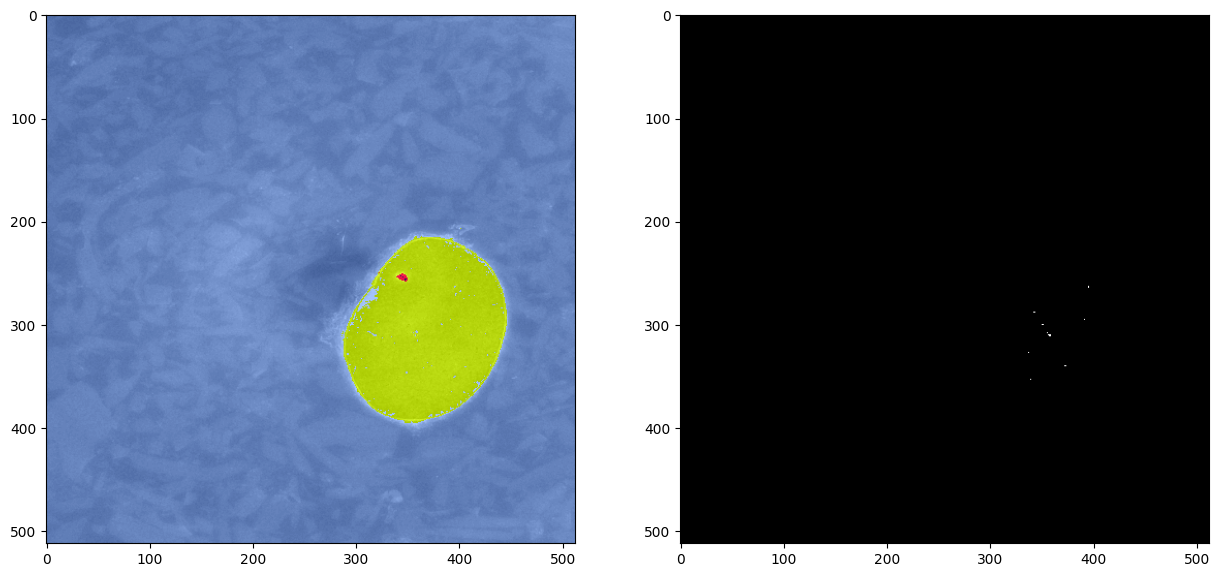

In [87]:
# Cell for sanity checking dataset methods

# Grab item from training dataset
print(trds.image_paths)
image, label = trds.__getitem__(1)

# Ensure shapes are correct
print(f"Image Size: {image.shape}")
print(f"Label Size: {label.shape}")

# Convert to numpy for processing later
image = image.numpy()
label = label.numpy()

# Check that labels are in correct range
print(f"Unique Label Values: {np.unique(label)}") # Should be 0 or 1

# Reshape for display
image = np.moveaxis(image, 0, -1)
image = (image * 255).astype('uint8') # Grab channel for gray

#print(np.where(label==0))

# Display image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(label, cmap='gray')
plt.show()

## Implement Segformer on the Vascular Dataset

### Loss Function Implementations for training

In [27]:
# Pytorch Dice Loss Implmentation Modified from: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
# DiceLoss for cross entropy loss (assumes num_classes > 1)
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        # Compute logits from sigmoid
        logits = torch.sigmoid(inputs)       

        # Compute softmax from logits
        sig = torch.sigmoid(logits)
        softmax = F.softmax(sig, dim=1) # Compute softmax to get probs

        probs, _ = torch.max(softmax, dim=1)

        # Seg cts in [0,1], masks discrete one-hot with labels [0,1]
        intersection = (probs * targets).sum()
        dice = (2. * intersection + 1) / (probs.sum() + targets.sum() + 1)
        
        return 1 - dice

# Weighted cross entropy loss using unnormalized logits
class WeightedCE(torch.nn.Module):
    def __init__(self, weights):
        super(WeightedCE, self).__init__()
        self.weights = weights
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights[1]))

    def forward(self, logits, targets):

        # Clamp for numerical stability
        #logits = torch.clamp(logits, min=1e-7, max=1-1e-7)
        mx, _ = torch.max(logits, dim=1) # Take largest unnormalized logit

        #sig = torch.sigmoid(logits)
        #softmax = F.softmax(logits, dim=1) # Compute softmax to get probs

        mx = torch.flatten(mx)
        targets = torch.flatten(targets)

        loss = self.criterion(mx, targets)
        return loss
        #loss = (-1 * self.weights[1] * targets * torch.log(probs)) - (self.weights[0] * (1 - targets) * torch.log(1 - probs))
        #return torch.mean(loss)

        #loss = self.criterion(preds, targets)

In [28]:
# Adopted from here: https://github.com/huggingface/transformers/issues/15819 (Thanks Niels!)

class SegFormerCustom(transformers.SegformerPreTrainedModel):
	def __init__(self, config, pretrained):
		super().__init__(config)
		self.segformer = transformers.SegformerForSemanticSegmentation.from_pretrained(pretrained, num_labels=config.num_labels)
		self.pretrained_path = pretrained
		self.num_labels = config.num_labels
		self.loss_func = WeightedCE(torch.tensor([1, 1]))

	def forward(self, pixel_values, labels=None):
		# get raw logits from segformer model
		outputs = self.segformer(pixel_values, labels)
		return outputs.logits, outputs.loss

		"""
		logits = outputs.logits
		loss = None
		if labels is not None: # Training
			upsampled_logits = F.interpolate(logits,
					size=pixel_values.size()[2:], # (height, width)
					mode='bilinear',
					align_corners=False)

			# Compute DiceBCE loss using logits from segformer
			loss = self.loss_func(upsampled_logits, labels.float())

		return logits, loss
		"""

In [29]:
# Create configuration for Segformer Model
config = transformers.SegformerConfig(num_labels=1) # 1 label = binary classification

# Grab pretrained model
# Use mit-b0 right now because it is the most lightweight
model = SegFormerCustom(config, 'nvidia/mit-b0')

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_25231/4030717513.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().det

In [30]:
# Move model to GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device
model = model.to(device) # Send model to device before creating optimizer

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000006) # Segformer Default LR: 0.000006

# Learning Rate Scheduler. Not in use right now because of transfer learning
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1./4., end_factor=1.)

In [40]:
# Training Loop
total_steps = len(train_loader)
epochs = 25

train_loss_avg = []
val_loss_avg = []

# Train network
for ep in range(epochs):

	per_epoch_loss_train = []
	per_epoch_loss_val = []

	# Training
	for idx, (images, masks) in enumerate(tqdm(train_loader)):
		# Convert vars to GPU
		images = images.float().to(device)
		masks = masks.type(torch.LongTensor).to(device)

		output = model(pixel_values=images, labels=masks)
		loss = output[1]
		loss.backward()

		optimizer.step()
		#scheduler.step()
		optimizer.zero_grad()

		# Save batches loss
		per_epoch_loss_train.append(loss.item())

	print(f"Epoch: {ep}: Training Loss: {np.mean(np.array(per_epoch_loss_train))}")

	# Validation
	for idx, (images, masks) in enumerate(tqdm(valid_loader)):
		# Convert vars to GPU
		images = images.float().to(device)
		masks = masks.type(torch.LongTensor).to(device)

		output = model(pixel_values=images, labels=masks)
		loss = output[1]

		# Save batches loss
		per_epoch_loss_val.append(loss.item())

	train_loss_avg.append(np.mean(np.array(per_epoch_loss_train)))
	val_loss_avg.append(np.mean(np.array(per_epoch_loss_val)))

# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

100%|██████████| 228/228 [00:32<00:00,  7.03it/s]


Epoch: 0: Training Loss: 0.022313237423077226


100%|██████████| 228/228 [00:32<00:00,  7.03it/s]


Epoch: 1: Training Loss: 0.021123239182327922


100%|██████████| 228/228 [00:32<00:00,  7.03it/s]


Epoch: 2: Training Loss: 0.019987139450549557


100%|██████████| 228/228 [00:32<00:00,  6.99it/s]


Epoch: 3: Training Loss: 0.018609518844944734


100%|██████████| 228/228 [00:32<00:00,  6.98it/s]


Epoch: 4: Training Loss: 0.01709530447617892


100%|██████████| 228/228 [00:32<00:00,  6.92it/s]


Epoch: 5: Training Loss: 0.01589040681638085


100%|██████████| 228/228 [00:32<00:00,  6.98it/s]


Epoch: 6: Training Loss: 0.015038460133629934


100%|██████████| 228/228 [00:32<00:00,  6.99it/s]


Epoch: 7: Training Loss: 0.014427988553060251


100%|██████████| 228/228 [00:32<00:00,  6.96it/s]


Epoch: 8: Training Loss: 0.013925710903366277


100%|██████████| 228/228 [00:32<00:00,  6.97it/s]


Epoch: 9: Training Loss: 0.013440708923888834


100%|██████████| 228/228 [00:32<00:00,  6.98it/s]


Epoch: 10: Training Loss: 0.012872921568423248


100%|██████████| 228/228 [00:32<00:00,  6.92it/s]


Epoch: 11: Training Loss: 0.012126171021934664


100%|██████████| 228/228 [00:31<00:00,  7.25it/s]


Epoch: 12: Training Loss: 0.011223588771954701


100%|██████████| 228/228 [00:31<00:00,  7.17it/s]


Epoch: 13: Training Loss: 0.010340839395659012


100%|██████████| 228/228 [00:30<00:00,  7.37it/s]


Epoch: 14: Training Loss: 0.009610021787107383


100%|██████████| 228/228 [00:30<00:00,  7.37it/s]


Epoch: 15: Training Loss: 0.009045961265975054


100%|██████████| 228/228 [00:30<00:00,  7.40it/s]


Epoch: 16: Training Loss: 0.008622002058760509


100%|██████████| 228/228 [00:31<00:00,  7.35it/s]


Epoch: 17: Training Loss: 0.00829797772396552


100%|██████████| 228/228 [00:31<00:00,  7.23it/s]


Epoch: 18: Training Loss: 0.008034446928241666


100%|██████████| 228/228 [00:30<00:00,  7.40it/s]


Epoch: 19: Training Loss: 0.007818154752736487


100%|██████████| 228/228 [00:30<00:00,  7.37it/s]


Epoch: 20: Training Loss: 0.00763626160966069


100%|██████████| 228/228 [00:32<00:00,  6.92it/s]


Epoch: 21: Training Loss: 0.007477979161449822


100%|██████████| 228/228 [00:32<00:00,  7.07it/s]


Epoch: 22: Training Loss: 0.00733750198024178


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 23: Training Loss: 0.007211750460045184


100%|██████████| 228/228 [00:32<00:00,  6.93it/s]


Epoch: 24: Training Loss: 0.0070975670558318755


100%|██████████| 57/57 [00:05<00:00, 11.00it/s]


In [27]:
# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

In [41]:
print(train_loss_avg)

[0.022313237423077226, 0.021123239182327922, 0.019987139450549557, 0.018609518844944734, 0.01709530447617892, 0.01589040681638085, 0.015038460133629934, 0.014427988553060251, 0.013925710903366277, 0.013440708923888834, 0.012872921568423248, 0.012126171021934664, 0.011223588771954701, 0.010340839395659012, 0.009610021787107383, 0.009045961265975054, 0.008622002058760509, 0.00829797772396552, 0.008034446928241666, 0.007818154752736487, 0.00763626160966069, 0.007477979161449822, 0.00733750198024178, 0.007211750460045184, 0.0070975670558318755]


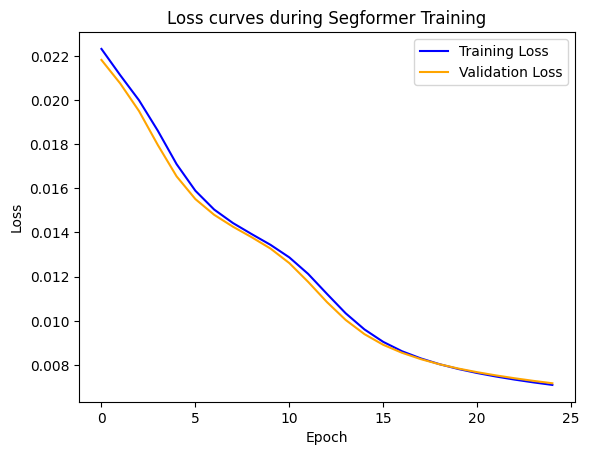

In [42]:
# Plot results
plt.plot(range(0, len(train_loss_avg)), train_loss_avg, label="Training Loss", color="blue")
plt.plot(range(0, len(val_loss_avg)), val_loss_avg, label="Validation Loss", color="orange")
plt.title("Loss curves during Segformer Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show();

### Test Trained Segformer Model

In [101]:
# Decode outputs from Segformer's unnormalized logits

def decodeSegformer(logits, mask):
	
	upsampled_logits = F.interpolate(logits,
		size=image.size()[2:], # (height, width)
		mode='bilinear',
		align_corners=False)

	probs = torch.sigmoid(upsampled_logits)

	# Seg cts in [0,1], masks discrete one-hot with labels [0,1]
	intersection = (probs * mask).sum()
	dice = (2. * intersection + 1) / (probs.sum() + mask.sum() + 1)

	# pred above .5 = 1, below = 0
	seg = np.round(probs)

	return seg, dice

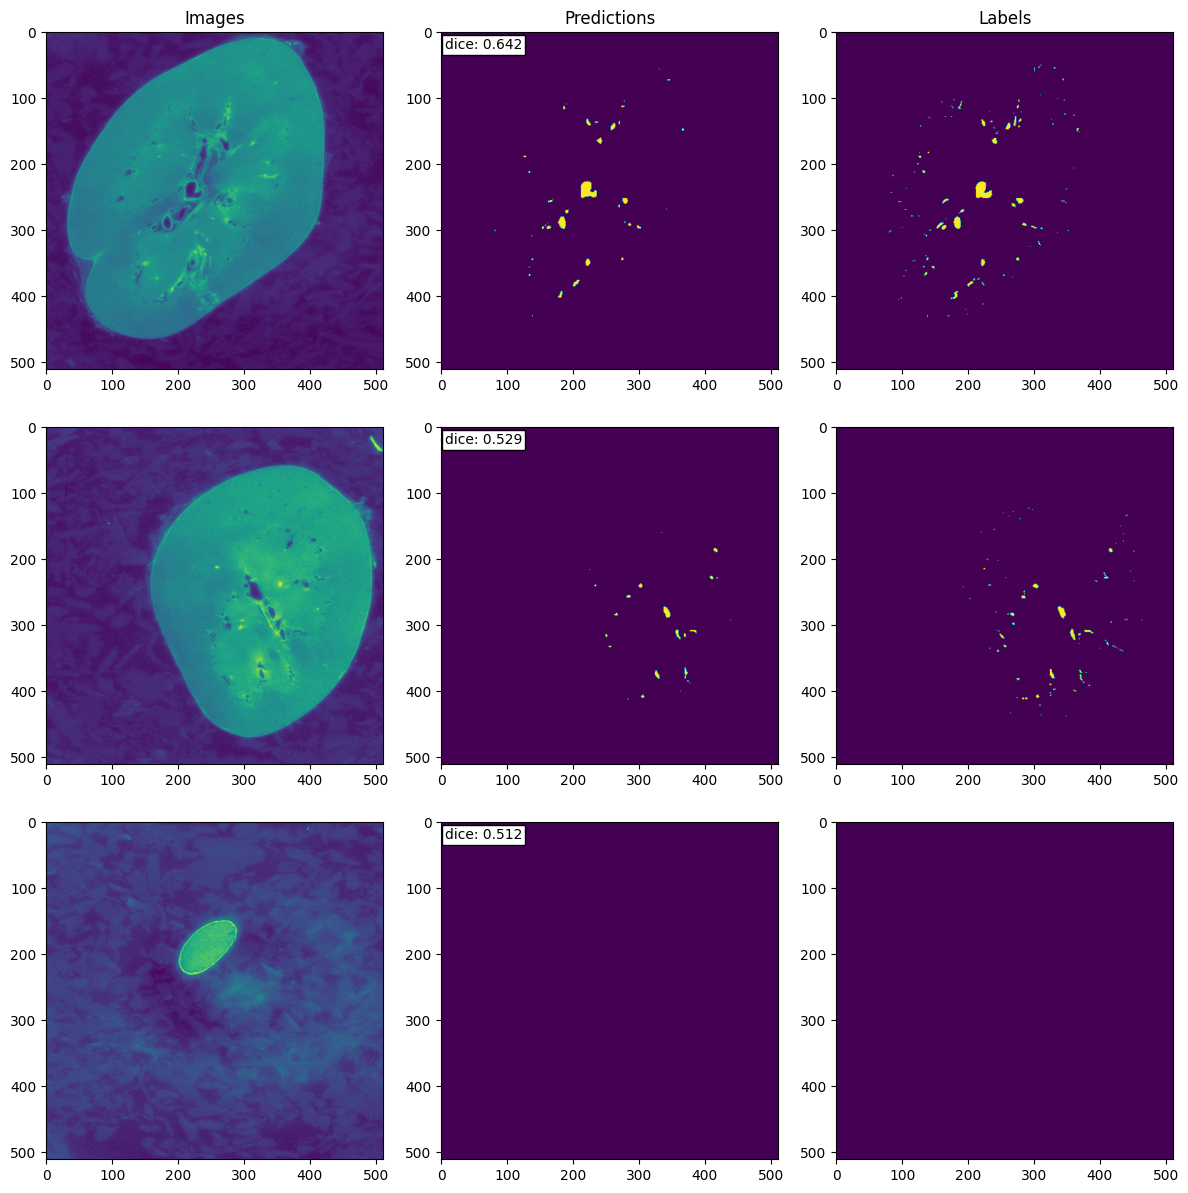

In [102]:
# Test the trained segformer model

with torch.no_grad():

    segs = []
    dices = []
    images = []
    masks = []

    for i in range(0, 3):
        image, mask = valds.__getitem__(i)
        #image, _ = teds.__getitem__(i)

        #mask = np.zeros((1, 1, 512, 512))

        images.append(image)
        masks.append(mask)

    for image, mask in zip(images, masks):
        image = image.to(device)
        mask = mask.to(device)

        image = torch.unsqueeze(image, 0)
        mask = torch.unsqueeze(mask, 0)
        outputs = model(pixel_values=image, labels=mask)
        logits = outputs[0].cpu()
        mask = mask.cpu()

        seg, dice = decodeSegformer(logits, mask)

        dices.append(dice)
        segs.append(seg)

    # Convert images and labels back to device
    images = [x.cpu().numpy() for x in images]
    masks =  [x.cpu().numpy() for x in masks]

    # Show examples
    fig, ax = plt.subplots(3, 3, figsize = (12, 12))
    fig.tight_layout() # Make plot look better

    ax[0,0].set_title('Images')
    ax[0,1].set_title('Predictions')
    ax[0,2].set_title('Labels')

    # Images
    ax[0,0].imshow(images[0][0])
    ax[1,0].imshow(images[1][0])
    ax[2,0].imshow(images[2][0])

    # Predictions
    ax[0,1].imshow(np.squeeze(segs[0]))
    ax[0,1].text(5, 25, f'dice: {dices[0].item():.3f}', bbox={'facecolor': 'white', 'pad': 2})
    ax[1,1].imshow(np.squeeze(segs[1]))
    ax[1,1].text(5, 25, f'dice: {dices[1].item():.3f}', bbox={'facecolor': 'white', 'pad': 2})
    ax[2,1].imshow(np.squeeze(segs[2]))
    ax[2,1].text(5, 25, f'dice: {dices[2].item():.3f}', bbox={'facecolor': 'white', 'pad': 2})

    # Labels
    ax[0,2].imshow(masks[0])
    ax[1,2].imshow(masks[1])
    ax[2,2].imshow(masks[2])

    plt.show()

## Use Segment-Anything (SAM) to Attempt Zero-Shot Segmentation

In [10]:
# Import SAM model

checkpoint = os.path.join(os.path.join(os.getcwd(), 'model'), 'sam_vit_h_4b8939.pth')

device = 'cuda:0' if torch.cuda.is_available else 'cpu'

sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
# Grab a few random images from the training set
idxs = np.random.choice(np.arange(Xtr.shape[0]), 3)

images = [trds.__getitem__(x)[0] for x in idxs]
labels = [trds.__getitem__(x)[1] for x in idxs]

# Make prediction
totalmasks = []

for image in images:
	masks = mask_generator.generate(image)
	totalmasks.append(np.array(masks))

# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

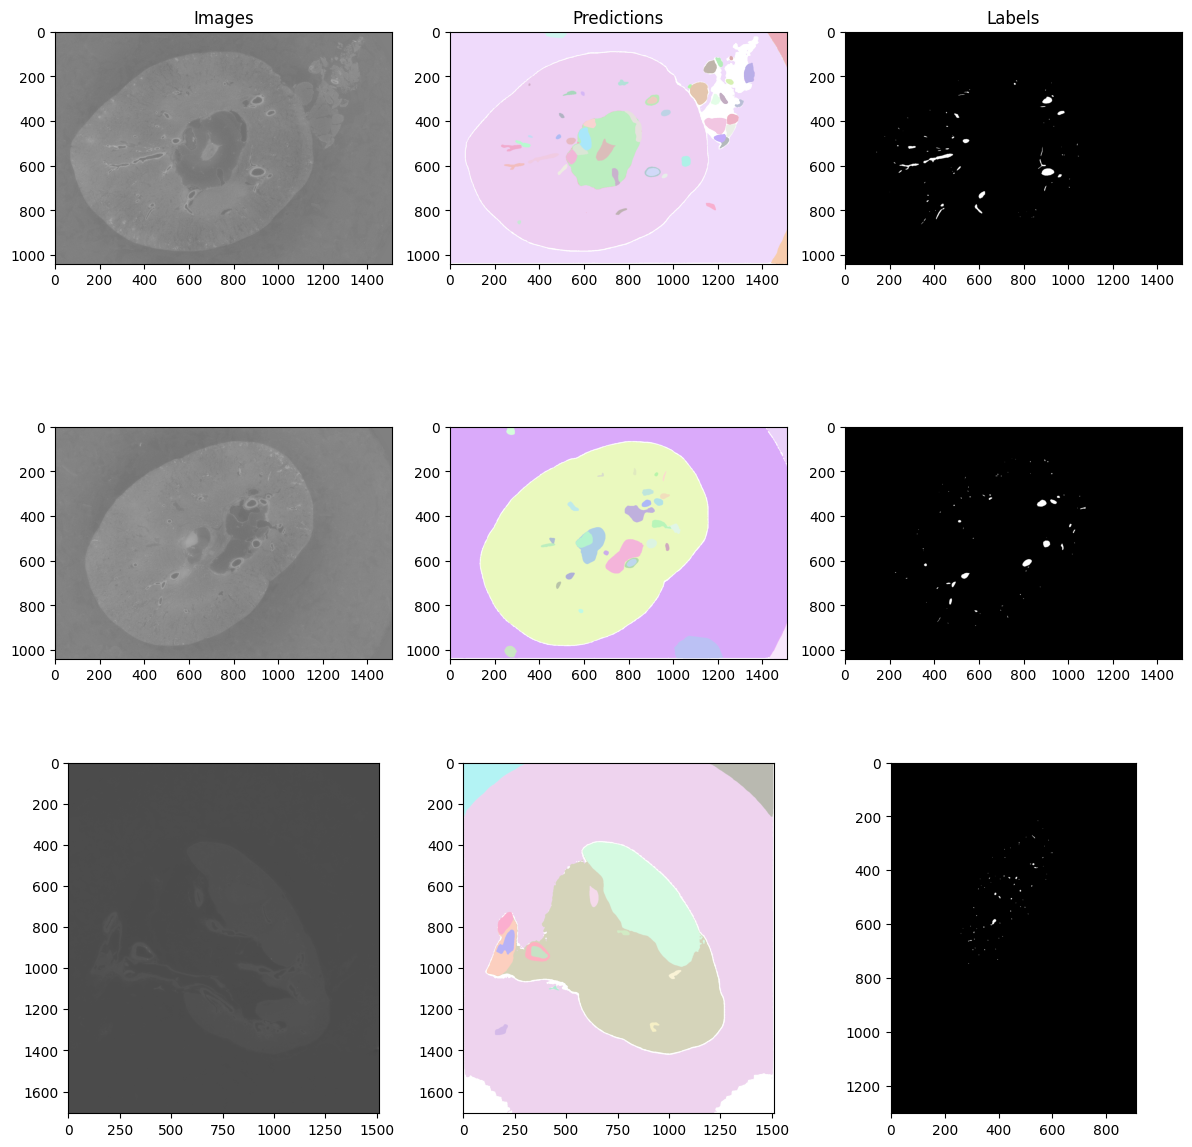

In [14]:
# From segment-anything automatic_mask_generator_example.ipynb in the FAIR Github repository
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))

    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    return img

# Show examples
fig, ax = plt.subplots(3, 3, figsize = (12, 12))
fig.tight_layout() # Make plot look better

ax[0,0].set_title('Images')
ax[0,1].set_title('Predictions')
ax[0,2].set_title('Labels')

# Images
ax[0,0].imshow(images[0])
ax[1,0].imshow(images[1])
ax[2,0].imshow(images[2])

# Predictions
ax[0,1].imshow(show_anns(totalmasks[0]))
ax[0,1].set_autoscale_on(False)
ax[1,1].imshow(show_anns(totalmasks[1]))
ax[1,1].set_autoscale_on(False)
ax[2,1].imshow(show_anns(totalmasks[2]))
ax[2,1].set_autoscale_on(False)

# Labels
ax[0,2].imshow(labels[0])
ax[1,2].imshow(labels[1])
ax[2,2].imshow(labels[2])

plt.show()

### Zero-shot SAM Performance

Straight out of the box, SAM performs poorly for our vascular dataset challenge. Looking at the middle column, it is evident that some segmentation is taking place, but it isn't relevant to the vascular problem. The list of issues is summarized below. 

1. SAM is performing instance segmentation, but we have a binary segmentation problem
2. The structure of biological images differs heavily from "natural images". Examples: No color features (images are grayscale upscaled to RGB), lower Signal to Noise Ratio (qualitative)
3. SAM does not have knowledge of the vascular problem we are trying to solve.
4. SAM needs to be prompted (bounding box, text, etc) which isn't included in our dataset. We could potentially augment bounding boxes, but the dataset doesn't seem that well suited to rectangular boxes. 

Conclusion:  
SAM is not a suitable solution for this problem with this dataset.

### What part of SAM do we have control over?

